In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pickle

In [13]:
# Setup directory paths to train and test images
train_dir = "/home/usd.local/sonyreddy.gurram/rizk_lab/shared/neeraj_dattu/dataset/Training"
test_dir = "/home/usd.local/sonyreddy.gurram/rizk_lab/shared/neeraj_dattu/dataset/Testing"

# Set up the data generators for training and testing images
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [15]:
# Load the pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a global average pooling layer and a dense layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [16]:
# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=50, validation_data=test_generator)

# Get the training results
train_loss = history.history['loss']
test_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Store the training results in a dictionary
trained_results = {
    'train_loss': train_loss,
    'test_loss': test_loss,
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy
}

# Save the training results to a file
with open('resnet_results.pkl', 'wb') as f:
    pickle.dump(trained_results, f)

# Save an object to a file
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [7]:
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# Load the model from a file
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)
    
with open('resnet_results.pkl', 'rb') as f:
    resnet_results = pickle.load(f)

# Assuming you have a directory with test images
test_dir = "/home/usd.local/sonyreddy.gurram/rizk_lab/shared/neeraj_dattu/dataset/Testing"

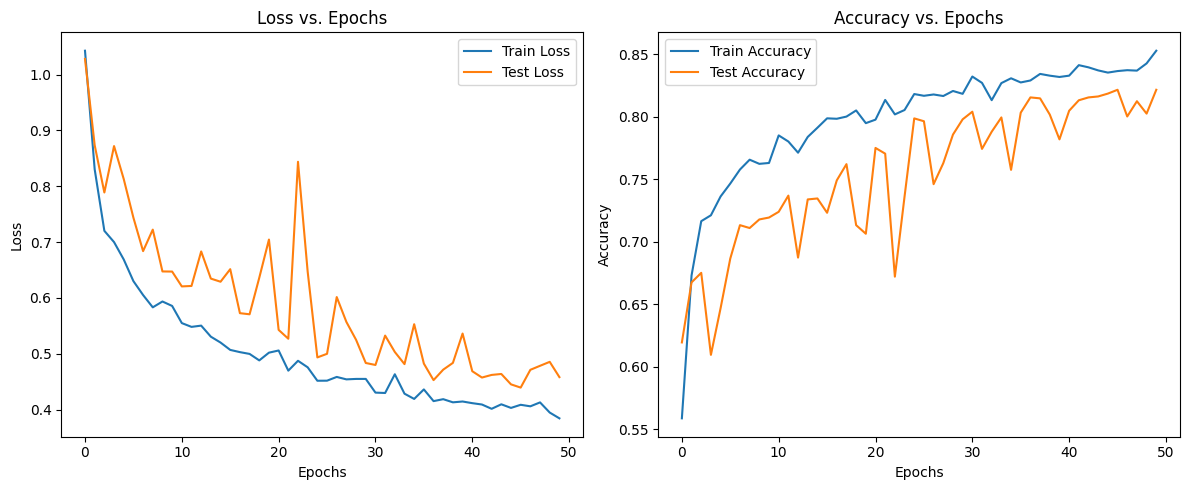

In [9]:
import matplotlib.pyplot as plt

# Create a new figure for the plots
plt.figure(figsize=(12, 5))

# Create the loss plot
plt.subplot(1, 2, 1)
plt.plot(resnet_results['train_loss'], label='Train Loss')
plt.plot(resnet_results['test_loss'], label='Test Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Create the accuracy plot
plt.subplot(1, 2, 2)
plt.plot(resnet_results['train_accuracy'], label='Train Accuracy')
plt.plot(resnet_results['test_accuracy'], label='Test Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [10]:
# Set up the data generator for testing images
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true class labels
y_true = test_generator.classes

# Compute the classification report
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())

print(report)


Found 1311 images belonging to 4 classes.


/home/usd.local/sonyreddy.gurram/anaconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 352ms/step
              precision    recall  f1-score   support

      glioma       0.87      0.61      0.72       300
  meningioma       0.68      0.72      0.70       306
     notumor       0.93      0.95      0.94       405
   pituitary       0.80      0.97      0.88       300

    accuracy                           0.82      1311
   macro avg       0.82      0.81      0.81      1311
weighted avg       0.83      0.82      0.82      1311



[[182  94   4  20]
 [ 22 219  27  38]
 [  1   5 386  13]
 [  4   6   0 290]]


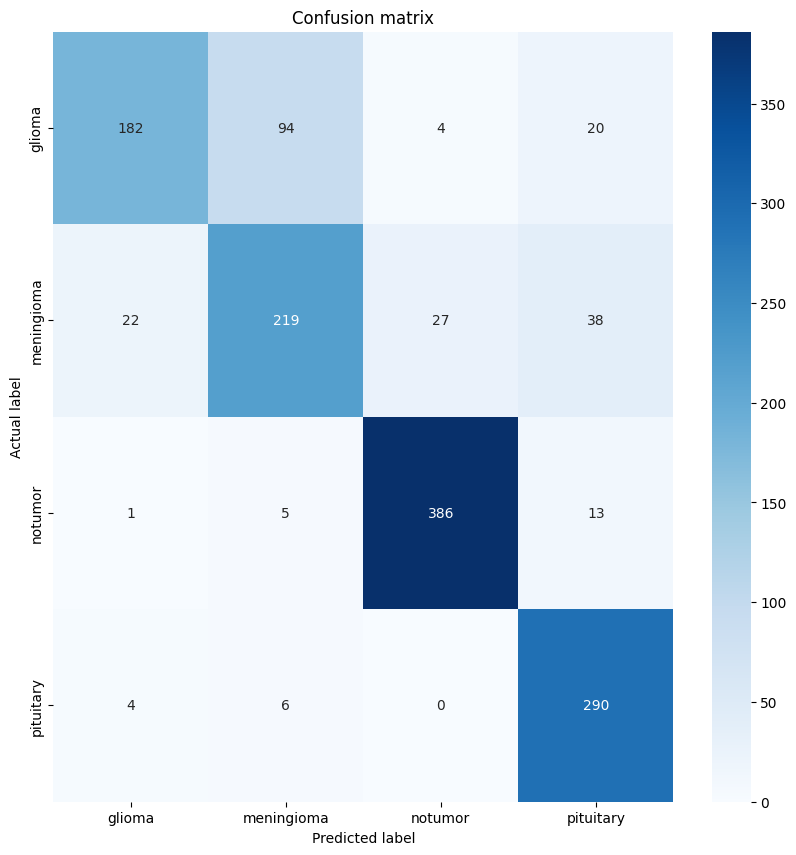

In [11]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

print(cm)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()
